In [2]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from hazm import  word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

import random

from IPython.display import clear_output
from tqdm.notebook import tqdm
from hazm import word_tokenize, Normalizer

In [5]:
class Vectorizer():
    def __init__(self, corp_path):
        self.corp_path = corp_path
        self.normalizer = Normalizer()
    
    def upload_corp(self):
        with open(self.corp_path, 'r', encoding='utf-8') as f:
            self.corp = list(set(f.read().split('\n')))
        
        tokenized_corp = []
        for text in self.corp:
            normalized_text = self.normalizer.normalize(text)
            tokens = word_tokenize(normalized_text)
            split_tokens = []
            for token in tokens:
                if ' ' in token:
                    split_tokens.extend(token.split(' '))
                else:
                    split_tokens.append(token)
            tokenized_corp.append(' '.join(split_tokens))
        
        self.corp = tokenized_corp
    
    def log(self, part):
        clear_output(wait=True)
        print(f'{part} is processing')
        
    def make_tf_idf_matrix(self, token_pattern=None):
        if token_pattern:
            self.tfidf = TfidfVectorizer(token_pattern=token_pattern)
        else:
            self.tfidf = TfidfVectorizer()
            
        self.A = self.tfidf.fit_transform(self.corp)
        self.feature_list = self.tfidf.get_feature_names_out()
        
    def make_svd(self, n=30):
        self.u, self.sigma, self.vT = svds(self.A, n)
        self.singular_indicies = np.argsort(-self.sigma)
        
        self.u = self.u[:, self.singular_indicies]
        self.sigma = np.diag(self.sigma[self.singular_indicies])
        self.vT = self.vT[self.singular_indicies, :]
        
        self.embedded_matrix = self.sigma@self.vT
        
        self.words_embedding_dict = dict(zip(self.feature_list, self.embedded_matrix.T))
    
    def get_emb_dict(self):
        
        self.log('Upload')
        self.upload_corp()
        self.log('TfIdf')
        self.make_tf_idf_matrix()
        self.log('SVD')
        self.make_svd(n=20)
        
        return self.words_embedding_dict

In [6]:
vect = Vectorizer('/content/persian_cleaned_corpus.txt')
emb_dict = vect.get_emb_dict()

SVD is processing


In [7]:
# Select 10 random keys from the embedding dictionary
keys = random.sample(emb_dict.keys(), 10)

# Print the embeddings of the selected keys, rounded to 4 decimal places
for k in keys:
    print(f'{k}: {emb_dict[k].round(4)}')

<ipython-input-7-2fc0304fd746>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(emb_dict.keys(), 10)


دیگرصورت: [ 0.0001  0.      0.     -0.0001 -0.0001 -0.      0.      0.     -0.
 -0.     -0.     -0.0001 -0.0001 -0.0001 -0.      0.      0.0001  0.0001
  0.0003  0.0001]
وکیلیکیا: [ 0.0001  0.     -0.0001  0.      0.      0.0001 -0.0001  0.     -0.
 -0.0003  0.0001 -0.     -0.0001 -0.     -0.0001 -0.      0.      0.0001
 -0.0001  0.0001]
نیرژا: [ 0. -0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0.  0.
 -0. -0.]
مهدهد: [ 0.001  -0.0009  0.0004  0.0009 -0.0004 -0.0008  0.0002 -0.0002 -0.0002
 -0.0004 -0.0001 -0.0007  0.0003 -0.0006  0.0001  0.0005  0.      0.0002
 -0.0002  0.0003]
شکمسنته: [ 0.      0.     -0.      0.      0.     -0.      0.0001  0.     -0.
  0.      0.     -0.     -0.     -0.      0.     -0.     -0.      0.
 -0.0001  0.    ]
دراثار: [ 0.0003 -0.0002  0.0001 -0.0001 -0.     -0.0002 -0.0002 -0.0003  0.0001
 -0.0002 -0.0003  0.0002  0.      0.      0.0001 -0.     -0.0001  0.0001
 -0.      0.    ]
ژلبا: [ 0.0001 -0.      0.     -0.0001 -0.     -0.     -0.0001

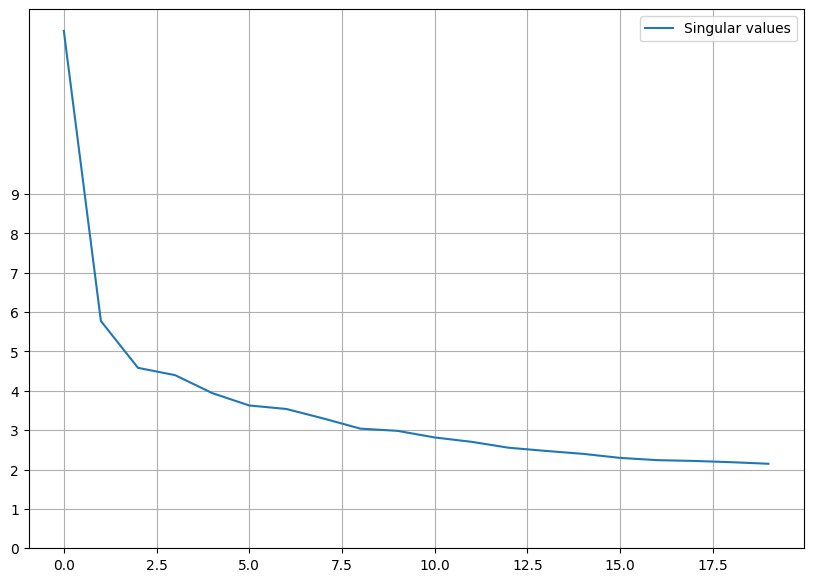

In [8]:
import matplotlib.pyplot as plt
s = np.diag(vect.sigma)

#print (vect.sigma)
plt.figure(figsize=(10, 7))
plt.plot(s, label='Singular values')
plt.grid()
plt.legend()
plt.yticks(range(0, 10))
plt.show()

In [9]:
import pickle

with open('per_emb_dict.pkl', 'wb') as f:
    pickle.dump(emb_dict, f)

In [ ]:
# import json
# import numpy as np

# # Convert numpy arrays to lists in the emb_dict dictionary
# emb_dict = {k: emb_dict[k].tolist() for k in emb_dict}

# # Save the emb_dict dictionary to a file
# with open('per_emb_dict.json', 'w') as f:
#     json.dump(emb_dict, f)